In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from cbrlib.evaluation.NumberInterpolationEvaluator import NumberInterpolationEvaluator, NumberInterpolationMetrics, NumberInterpolation
from cbrlib.model.AssemblyClass import AssemblyClass
from cbrlib.model.Attribute import Attribute
from cbrlib.model.EnumerationPredicate import EnumerationPredicate
from cbrlib.model.FloatClass import FloatClass
from cbrlib.model.IntegerClass import IntegerClass
from cbrlib.model.RangePredicate import RangePredicate
from cbrlib.model.StringClass import StringClass

#plt.style.use('ggplot')

In [2]:
# Define the price class with minimum value of 10 and maximum value of 100000
price_class = FloatClass('Price')
min_ = price_class.create_object(10)
max_ = price_class.create_object(10000)
price_class.set_predicate(RangePredicate(min_, max_))

# Define inperpolation metrics with a tolerance if case is lesser than query of 0
# -> Every case lower than the query will have 0 similarity
metrics = NumberInterpolationMetrics()
metrics.tolerance_if_more = 0.0
less_is_good = NumberInterpolationEvaluator('LessIsGood', min_.get_value(), max_.get_value(), metrics)

# Define the same as above but use an origin value
# The lower the query the smaller is the vicinity
metrics = NumberInterpolationMetrics()
metrics.tolerance_if_more = 0.0
metrics.origin = 10
metrics.use_origin = True
metrics.tolerance_if_more = 0.0
less_is_good_with_origin = NumberInterpolationEvaluator('LessIsGoodUseOrigin',
                                                        min_.get_value(), max_.get_value(), metrics)

metrics = NumberInterpolationMetrics()
metrics.tolerance_if_less = 0.0
metrics.origin = min_.get_value()
metrics.use_origin = True
metrics.tolerance_if_less = 0.3
metrics.tolerance_if_more = 0.1
metrics.linearity_if_less = 0.5
metrics.linearity_if_more = 3
metrics.set_interpolation_if_less(NumberInterpolation.Sigmoid)
metrics.set_interpolation_if_more(NumberInterpolation.Sigmoid)
real_behaviour = NumberInterpolationEvaluator('RealBehaviour',
                                                        min_.get_value(), max_.get_value(), metrics)
print(metrics.to_serializable())

{'cyclic': False, 'origin': 10.0, 'useOrigin': True, 'equalIfLess': 0.0, 'toleranceIfLess': 0.3, 'linearityIfLess': 0.5, 'equalIfMore': 0.0, 'toleranceIfMore': 0.1, 'linearityIfMore': 3, 'interpolationIfLess': 'Sigmoid', 'interpolationIfMore': 'Sigmoid'}


In [3]:
query = price_class.read_object(500)

less_is_good_values = list()
less_is_good_with_origin_values = list()
real_behaviour_values = list()
steps = list()
for i in range(300, 600):
    steps.append(i)
    case = price_class.read_object(i)
    less_is_good_values.append(
        less_is_good.evaluate(query, case))
    less_is_good_with_origin_values.append(
        less_is_good_with_origin.evaluate(query, case))
    real_behaviour_values.append(real_behaviour.evaluate(query, case))

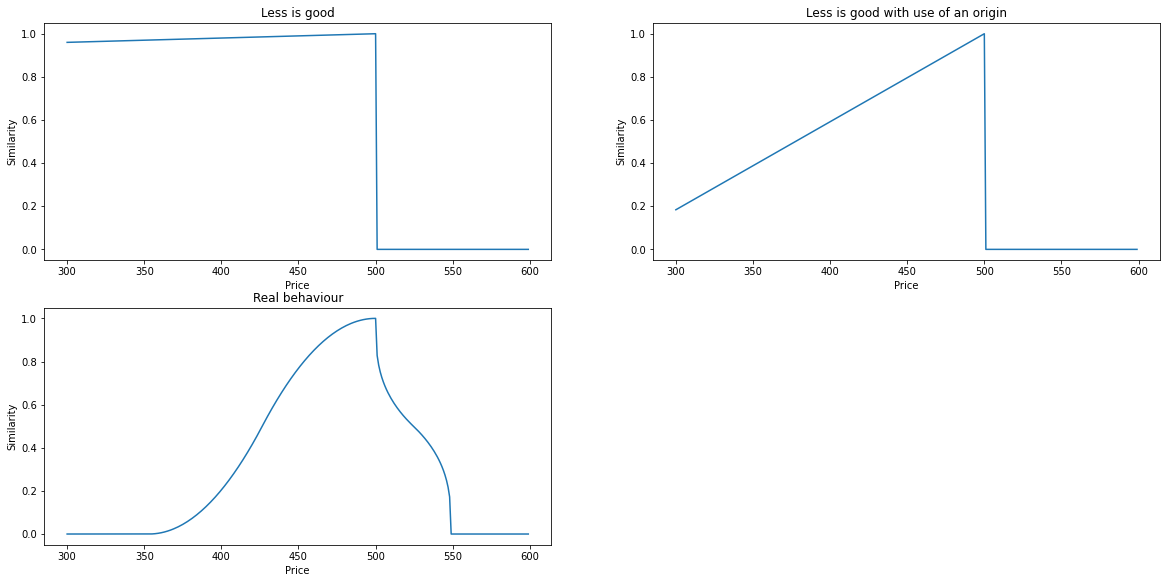

In [4]:
figure = plt.figure(2, figsize=(20, 9.6))
plt1 = figure.add_subplot(221)
plt2 = figure.add_subplot(222)
plt3 = figure.add_subplot(223)

plt1.plot(
    steps, less_is_good_values
)
plt1.set_title('Less is good')
plt1.set_xlabel(price_class.get_id())
plt1.set_ylabel('Similarity')
plt2.plot(
    steps, less_is_good_with_origin_values
)
plt2.set_title('Less is good with use of an origin')
plt2.set_xlabel(price_class.get_id())
plt2.set_ylabel('Similarity')

plt3.plot(
    steps, real_behaviour_values
)
plt3.set_title('Real behaviour')
plt3.set_xlabel(price_class.get_id())
plt3.set_ylabel('Similarity')

plt.show()